In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

import math
import matplotlib.pyplot as plt
#%matplotlib inline
# Input data files are available in the "./data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

sample_submission.csv
test.csv
train.csv



In [21]:
num_training = 41000
num_val = 1000
num_test = 28000
def get_MNIST_data():
    #read the data
    train_data = pd.read_csv('./data/train.csv').as_matrix()
    test_data = pd.read_csv('./data/test.csv').as_matrix()
    print(train_data.shape)
    print(test_data.shape)
    #shuffle the train_data before spliting for better generalization
    np.random.shuffle(train_data)
    # Split 1000 examples for validation
    X_train = train_data[1000:,1:]
    y_train = train_data[1000:,:1]
    X_val = train_data[:1000,1:]
    y_val= train_data[:1000,:1]
    X_test = test_data
    
    #Normalize the data:subtract the mean image 
    #Dividing the data by standard deviation is not necessary 
    #because all features are pixel values ranging between 0 to 255
    mean = np.mean(X_train, axis=0,dtype=np.int64)
    X_train -= mean
    X_val -= mean
    X_test -= mean
    return X_train,y_train,X_val,y_val,X_test,mean

In [22]:
X_train,y_train,X_val,y_val,X_test,mean = get_MNIST_data()
#Print out the range of values
range = np.ptp(np.ptp(X_train,axis=0),axis=0)
print('Range:', range)

#Reshape the data from 784 to 28x28 since it represents the image width and height
X_train = np.reshape(X_train,(-1,28,28,1))
X_val = np.reshape(X_val,(-1,28,28,1))
X_test = np.reshape(X_test,(-1,28,28,1))
y_train = np.reshape(y_train,-1)
y_val = np.reshape(y_val,-1)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)

(42000, 785)
(28000, 784)
('Range:', 255)
('Train data shape: ', (41000, 28, 28, 1))
('Train labels shape: ', (41000,))
('Validation data shape: ', (1000, 28, 28, 1))
('Validation labels shape: ', (1000,))
('Test data shape: ', (28000, 28, 28, 1))


## display the image

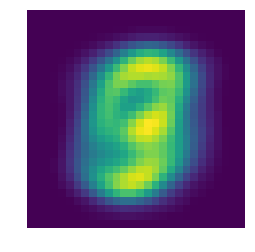

(784,)


In [23]:

image_width = 28
image_height = 28
def image_display(image):
    image = image.reshape(image_width,image_height)
    plt.imshow(image)
    plt.show() # add
    plt.axis('off')
#Display the image    
image_display(mean)

print(mean.shape)




## MNIST_Model:

Network architecture:Some of the good architectures for training include the following:

[conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]

[conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]

[batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]

The below architecture can be described as: [conv-relu-batchnorm-pool]x2 -> [affine-relu-batchnorm]->[affine] -> [softmax]


In [25]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 28, 28, 1 ])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

#Define Model
def MNISTmodel(X,y,is_training):
    Wconv1=tf.get_variable("Wconv1",shape=[5,5,1,64])
    bconv1=tf.get_variable("bconv1",shape=[64])
    Wconv2=tf.get_variable("Wconv2",shape=[5,5,64,128])
    bconv2=tf.get_variable("bconv2",shape=[128])
    W1=tf.get_variable("W1",shape=[7*7*128,1024])
    b1=tf.get_variable("b1",shape=[1024])
    W2=tf.get_variable("W2",shape=[1024,10])
    b2=tf.get_variable("b2",shape=[10])
    hconv1=tf.nn.relu(tf.nn.conv2d(X,Wconv1,strides=[1,1,1,1],padding='SAME')+bconv1)
    hbn1=tf.contrib.layers.batch_norm(hconv1,center=True, scale=True,is_training=is_training,scope='hbn1')
    hpool1=tf.nn.max_pool(hbn1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    hconv2=tf.nn.relu(tf.nn.conv2d(hpool1,Wconv2,strides=[1,1,1,1],padding='SAME')+bconv2)
    hbn2=tf.contrib.layers.batch_norm(hconv2,center=True, scale=True,is_training=is_training,scope='hbn2')
    hpool2=tf.nn.max_pool(hbn2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    hpool2_flat=tf.reshape(hpool2,(-1,7*7*128))
    hfc1=tf.nn.relu(tf.matmul(hpool2_flat,W1)+b1)
    hbn3=tf.contrib.layers.batch_norm(hfc1,center=True, scale=True,is_training=is_training,scope='hbn3')
    y_out=tf.matmul(hbn3,W2)+b2
    variable_list = [Wconv1,bconv1,Wconv2,bconv2,W1,b1,W2,b2]
    return(y_out,variable_list)
y_out,variable_list = MNISTmodel(X,y,is_training)

In [26]:
#mean_loss: a TensorFlow variable (scalar) with numerical loss
#optimizer: a TensorFlow optimizer
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10),logits=y_out))
optimizer = tf.train.AdamOptimizer(1e-3)

#batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    opt_op = optimizer.minimize(mean_loss)
# Create an ExponentialMovingAverage object
ema = tf.train.ExponentialMovingAverage(decay=0.9999)

# Create the shadow variables, and add ops to maintain moving averages
# of var0 and var1.
maintain_averages_op = ema.apply(variable_list)

# Create an op that will update the moving averages after each training
# step.  This is what we will use in place of the usual training op.
with tf.control_dependencies([opt_op]):
    train_step = tf.group(maintain_averages_op)


In [33]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in np.arange(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in np.arange(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [34]:

#Prediction
prediction = tf.argmax(y_out,1)


In [35]:

#Lets strat a session
sess = tf.Session()
sess.run(tf.global_variables_initializer())


Training
name: "group_deps"
op: "NoOp"
input: "^Adam"
input: "^ExponentialMovingAverage"

Iteration 0: with minibatch training loss = 3.06 and accuracy of 0
Iteration 100: with minibatch training loss = 0.165 and accuracy of 0
Iteration 200: with minibatch training loss = 0.113 and accuracy of 0
Iteration 300: with minibatch training loss = 0.0534 and accuracy of 0
Iteration 400: with minibatch training loss = 0.0279 and accuracy of 0
Epoch 1, Overall loss = 0.116 and accuracy of 0


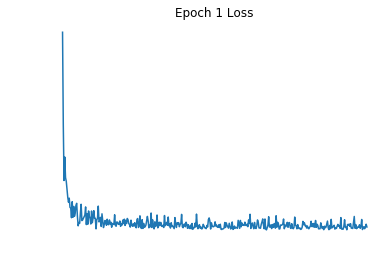

Validation
Epoch 1, Overall loss = 1.78 and accuracy of 0


(1.7792082138061522, 0)

In [36]:
print('Training')
print(train_step)
run_model(sess,y_out,mean_loss,X_train,y_train,1,100,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [30]:


predicted_labels = np.zeros(X_test.shape[0])
for i in np.arange(0,X_test.shape[0]/50,dtype=np.int64):
    start = i*50
    end = (i+1)*50
    predicted_labels[start:end] = sess.run(prediction,feed_dict={X: X_test[start:end,:],y: predicted_labels[start:end],is_training: False})



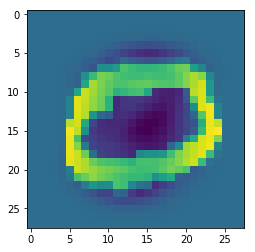

('predicted_labels:', 0.0)


In [31]:
#Lets check the output
image_display(X_test[1])
print('predicted_labels:',predicted_labels[1])

In [32]:


# save results
np.savetxt('submission_method3.csv', 
           np.c_[np.arange(1,len(X_test)+1),predicted_labels], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')



In [37]:
sess.close()